# Concrete Strength & Crack Prediction

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Load the data and Analyse

In [ ]:
print("Downloading dataset...")
path = kagglehub.dataset_download("elikplim/concrete-compressive-strength-data-set")
print(f"Dataset downloaded to: {path}")

# Find the CSV file within the downloaded folder
csv_files = glob.glob(os.path.join(path, "**", "*.csv"), recursive=True)

if not csv_files:
    raise FileNotFoundError("No CSV file found in the downloaded dataset path.")

# Load the first CSV found
df = pd.read_csv(csv_files[0])
print(f"Successfully loaded {len(df)} rows of data.")

# --- 2. Data Cleaning & Renaming ---
# The raw dataset has complex column names with units (e.g., "Cement (component 1)(kg in a m^3 mixture)")
# We rename them to simple identifiers for easier coding.
column_mapping = {
    df.columns[0]: 'cement',
    df.columns[1]: 'slag',
    df.columns[2]: 'fly_ash',
    df.columns[3]: 'water',
    df.columns[4]: 'superplasticizer',
    df.columns[5]: 'coarse_agg',
    df.columns[6]: 'fine_agg',
    df.columns[7]: 'age',
    df.columns[8]: 'strength'
}
df = df.rename(columns=column_mapping)
df.head()

Using Colab cache for faster access to the 'concrete-compressive-strength-data-set' dataset.
Dataset downloaded to: /kaggle/input/concrete-compressive-strength-data-set
Successfully loaded 1030 rows of data.


,cement,slag,fly_ash,water,superplasticizer,coarse_agg,fine_agg,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


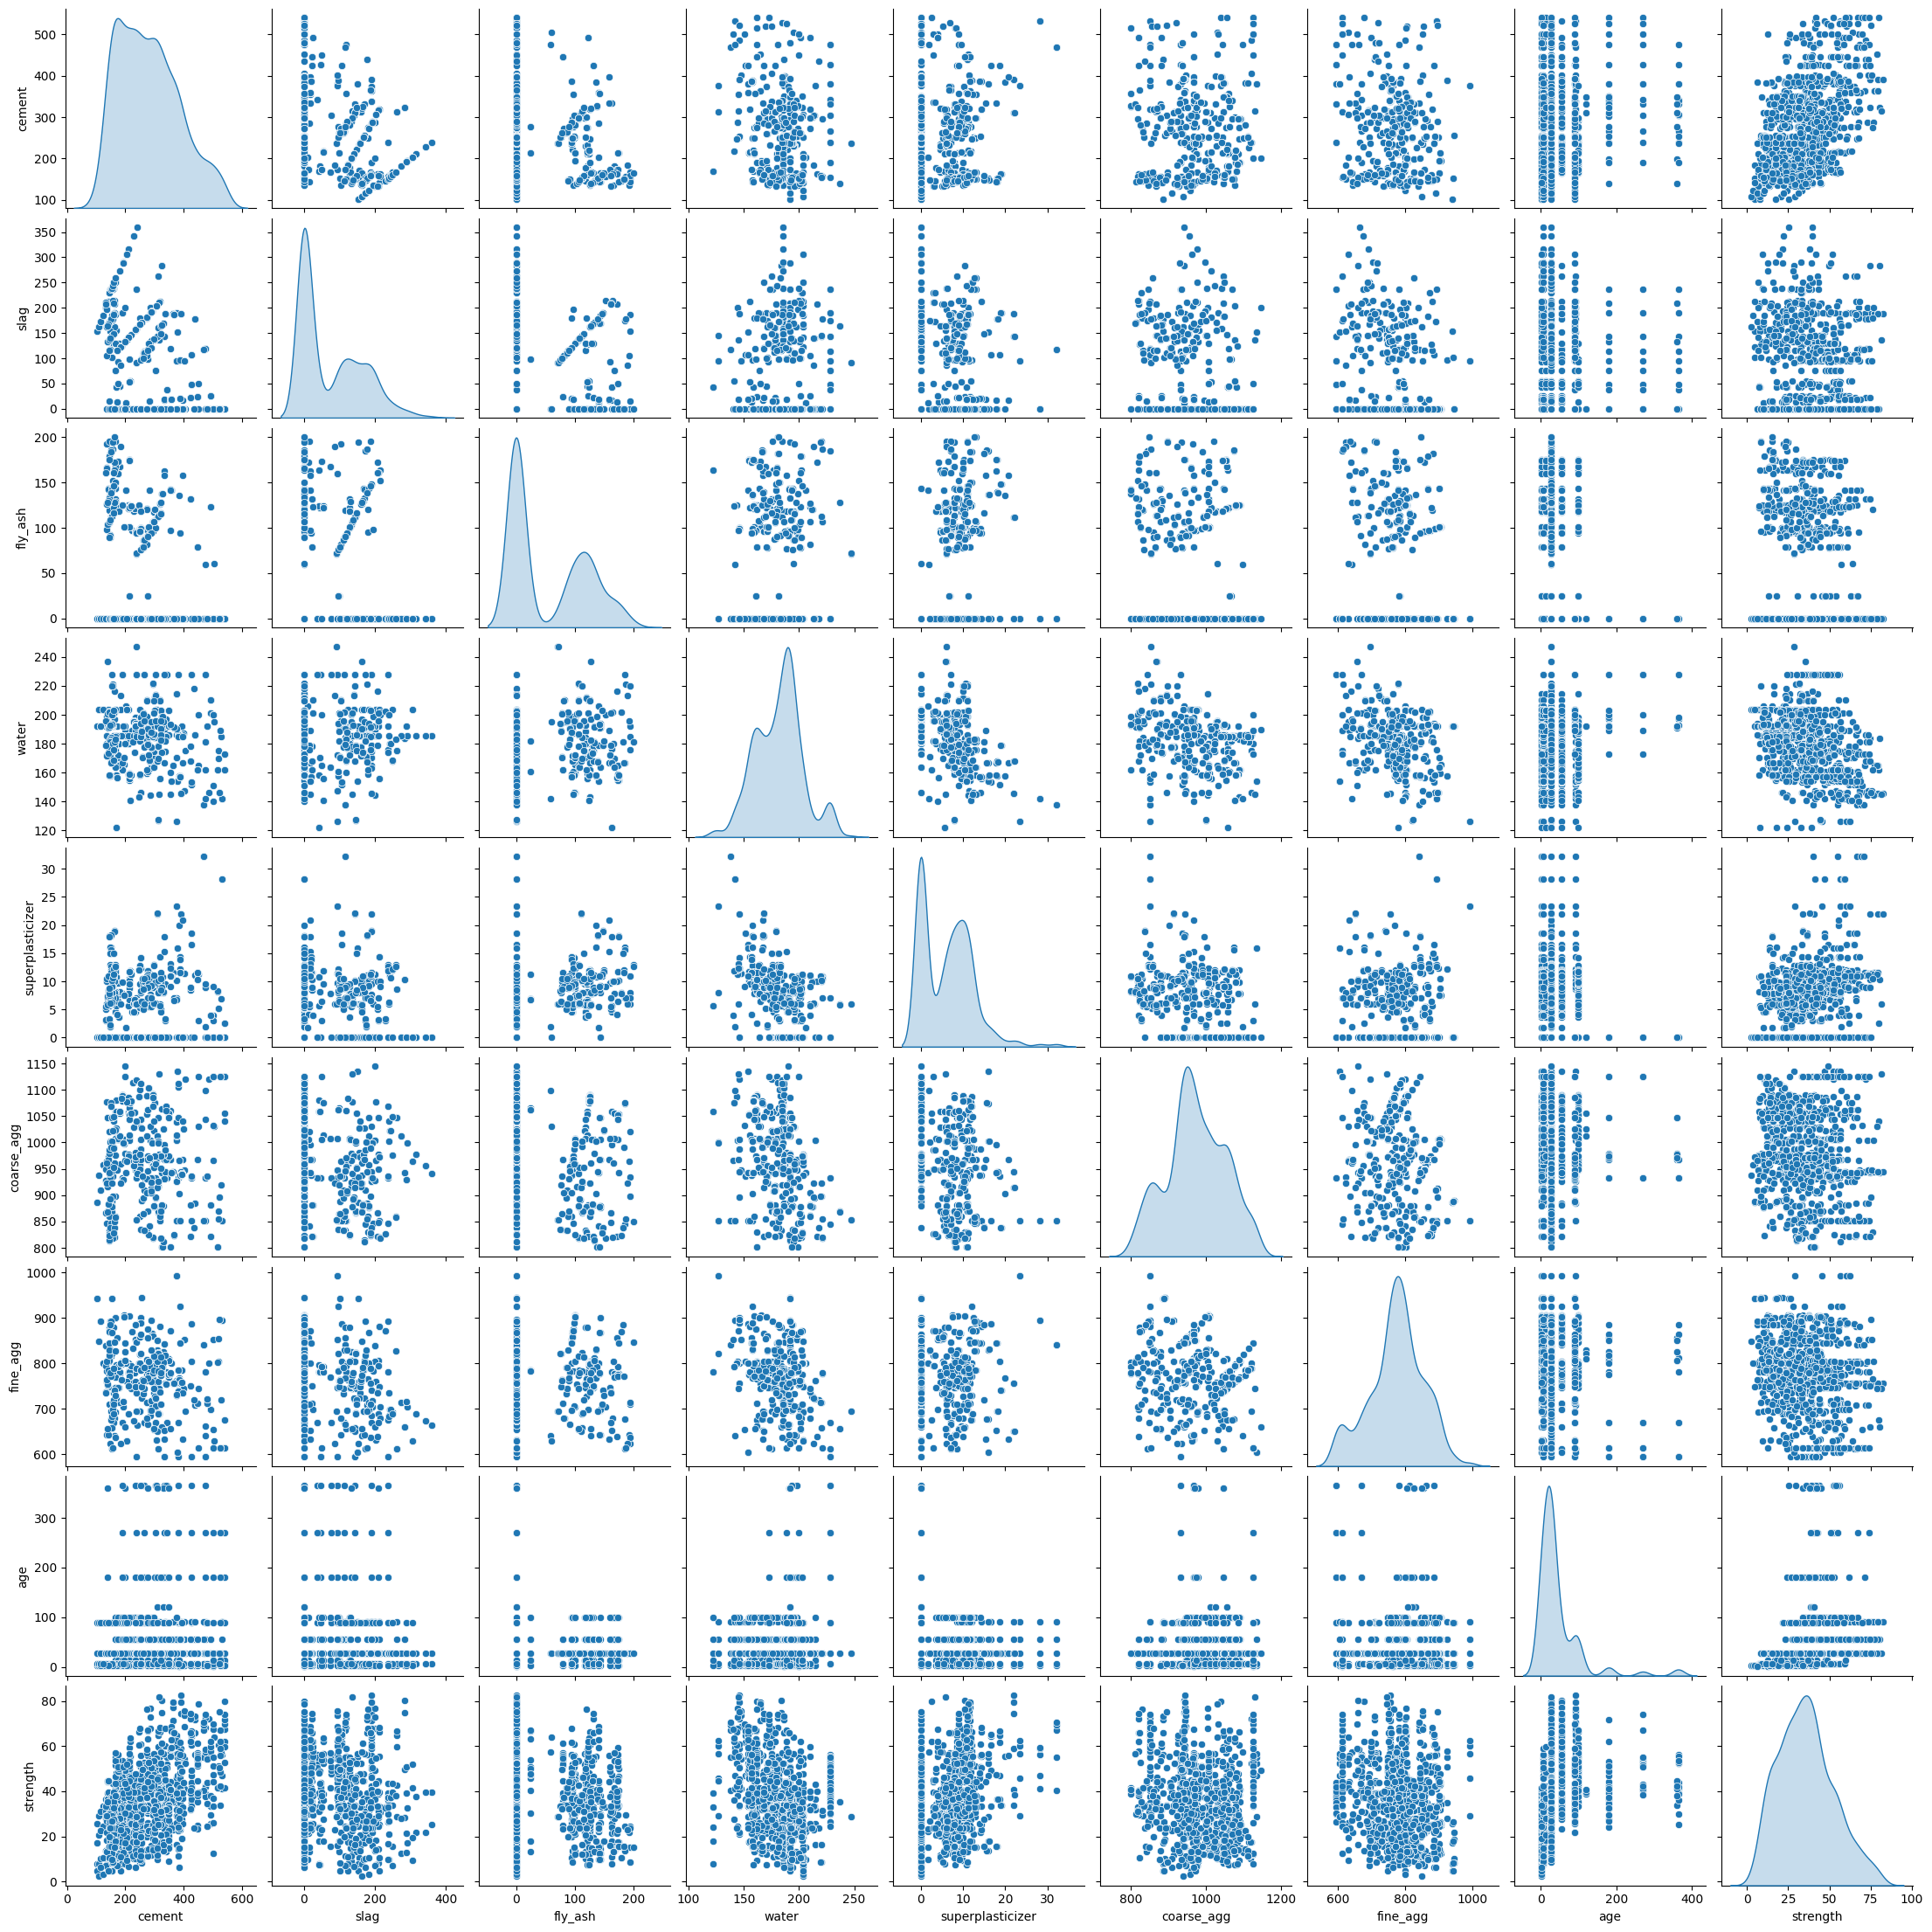

In [ ]:
sns.pairplot(df, diag_kind='kde')
plt.show()

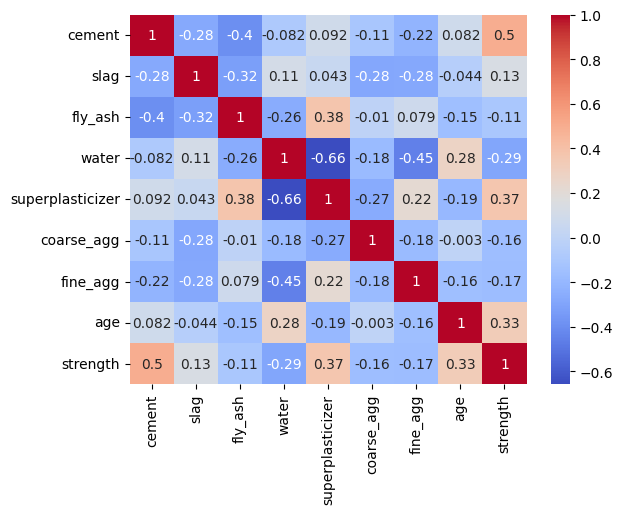

In [ ]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

## Data Preparation

In [ ]:
# Check for duplicates and handle them (common in this dataset)
print(f"Duplicates found before cleaning: {df.duplicated().sum()}")
df = df.drop_duplicates()
print(f"Data shape after cleaning: {df.shape}")

# --- 3. Preprocessing ---
X = df.drop('strength', axis=1)
y = df['strength']

# Split: 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Duplicates found before cleaning: 25
Data shape after cleaning: (1005, 9)


## Model definition

In [ ]:
model = keras.Sequential([
    # Explicit Input Layer - The modern standard
    keras.Input(shape=(X_train.shape[1],)),

    # Hidden Layers
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),

    # Output Layer
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,521 (45.00 KB)

 Trainable params: 11,521 (45.00 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [ ]:
print("\nTraining Neural Network on real research data...")
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=32,
    verbose=0
)
print("Training complete.")


Training Neural Network on real research data...
Training complete.


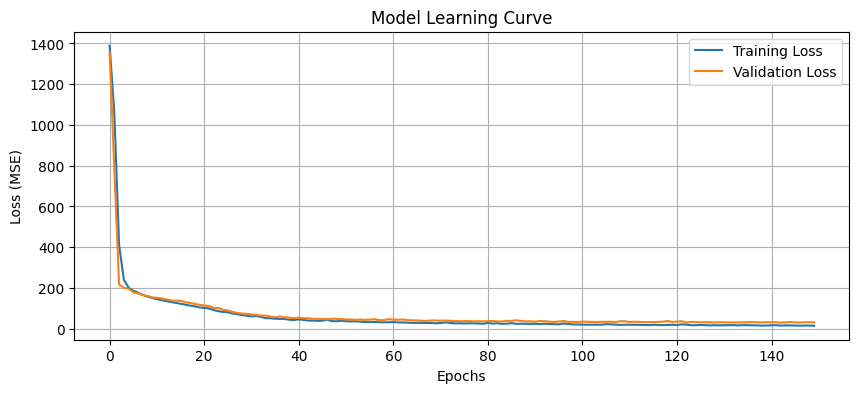

In [ ]:
# Graph: Training Loss over Epochs (To show convergence)
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
preds = model.predict(X_test_scaled).flatten()
r2 = r2_score(y_test, preds)
mae = mean_absolute_error(y_test, preds)

print(f"\nModel Performance on Test Set:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.2f} MPa")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Model Performance on Test Set:
R² Score: 0.8849
Mean Absolute Error: 4.29 MPa


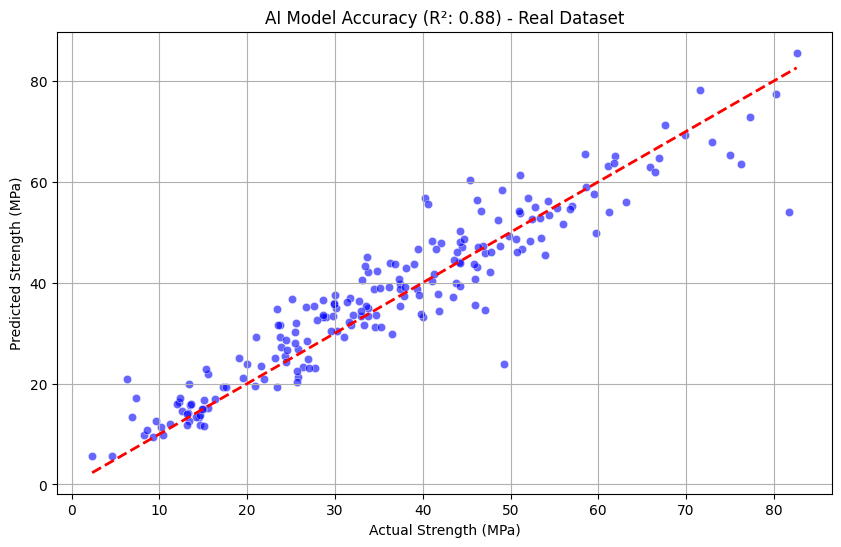

In [ ]:
# Graph: Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=preds, alpha=0.6, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) # Perfect prediction line
plt.xlabel('Actual Strength (MPa)')
plt.ylabel('Predicted Strength (MPa)')
plt.title(f'AI Model Accuracy (R²: {r2:.2f}) - Real Dataset')
plt.grid(True)
plt.show()

In [ ]:
def predict_mix_strength(cement, slag, fly_ash, water, superplast, coarse, fine, age):
    # Create a dictionary with the correct column names
    input_dict = {
        'cement': [cement],
        'slag': [slag],
        'fly_ash': [fly_ash],
        'water': [water],
        'superplasticizer': [superplast],
        'coarse_agg': [coarse],
        'fine_agg': [fine],
        'age': [age]
    }

    # Convert to DataFrame (so it matches the training data format)
    input_df = pd.DataFrame(input_dict)

    # Scale using the dataframe (Warning gone!)
    input_scaled = scaler.transform(input_df)

    # Predict
    prediction = model.predict(input_scaled, verbose=0)
    return prediction[0][0]

# Retest
pred = predict_mix_strength(350, 0, 0, 180, 0, 1000, 750, 28)
print(f"Predicted Strength: {pred:.2f} MPa")

Predicted Strength: 41.43 MPa


In [ ]:
import os
import shutil
import random

def create_sample_dataset(full_dataset_path, sample_output_path, num_samples_per_class=5):
    """
    Creates a sample dataset structure by copying a few random images
    from the full downloaded dataset.
    """
    print(f"\nCreating sample dataset in: {sample_output_path}...")

    # The specific Kaggle dataset structure has 'Positive' (crack) and 'Negative' (no crack) folders
    # Mapping Kaggle folder names to desired sample folder names
    class_mapping = {
        'Positive': 'crack',
        'Negative': 'no_crack'
    }

    # Ensure output directory exists
    if os.path.exists(sample_output_path):
        shutil.rmtree(sample_output_path)
    os.makedirs(sample_output_path)

    for kaggle_class, sample_class in class_mapping.items():
        source_class_dir = os.path.join(full_dataset_path, kaggle_class)
        dest_class_dir = os.path.join(sample_output_path, sample_class)

        # Create destination subdirectory (e.g., sample/crack)
        os.makedirs(dest_class_dir, exist_ok=True)

        # Get all image files in the source directory
        if not os.path.exists(source_class_dir):
            print(f"Warning: Source directory not found: {source_class_dir}")
            continue

        all_images = [f for f in os.listdir(source_class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if not all_images:
             print(f"Warning: No images found in: {source_class_dir}")
             continue

        # Select random samples
        selected_images = random.sample(all_images, min(len(all_images), num_samples_per_class))

        # Copy images
        print(f"Copying {len(selected_images)} images to {sample_class} folder...")
        for img_name in selected_images:
            src_path = os.path.join(source_class_dir, img_name)
            dst_path = os.path.join(dest_class_dir, img_name)
            shutil.copy2(src_path, dst_path)

    print(f"\nSample dataset created successfully at: {os.path.abspath(sample_output_path)}")
    print("Sample Structure:")
    for root, dirs, files in os.walk(sample_output_path):
        level = root.replace(sample_output_path, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        for f in files:
            print(f"{indent}    {f}")

# --- Main Execution ---

# 1. Download the data (Your provided code)
print("Attempting to download dataset via kagglehub...")
try:
    # Download latest version
    path = kagglehub.dataset_download("arnavr10880/concrete-crack-images-for-classification")
    print("Path to dataset files:", path)

    # Define where you want the sample to be located (e.g., a folder named 'concrete_sample' next to this script)
    sample_dir = os.path.join(os.getcwd(), "concrete_sample")

    # 2. Create the sample structure
    create_sample_dataset(path, sample_dir, num_samples_per_class=3)

except Exception as e:
    print(f"\nAn error occurred during download or sampling: {e}")
    print("Please ensure you have internet access and the 'kagglehub' library installed correctly.")

Attempting to download dataset via kagglehub...
Using Colab cache for faster access to the 'concrete-crack-images-for-classification' dataset.
Path to dataset files: /kaggle/input/concrete-crack-images-for-classification

Creating sample dataset in: /content/concrete_sample...
Copying 3 images to crack folder...
Copying 3 images to no_crack folder...

Sample dataset created successfully at: /content/concrete_sample
Sample Structure:
concrete_sample/
    no_crack/
        18176.jpg
        16745.jpg
        19008.jpg
    crack/
        09735.jpg
        06314.jpg
        06260.jpg


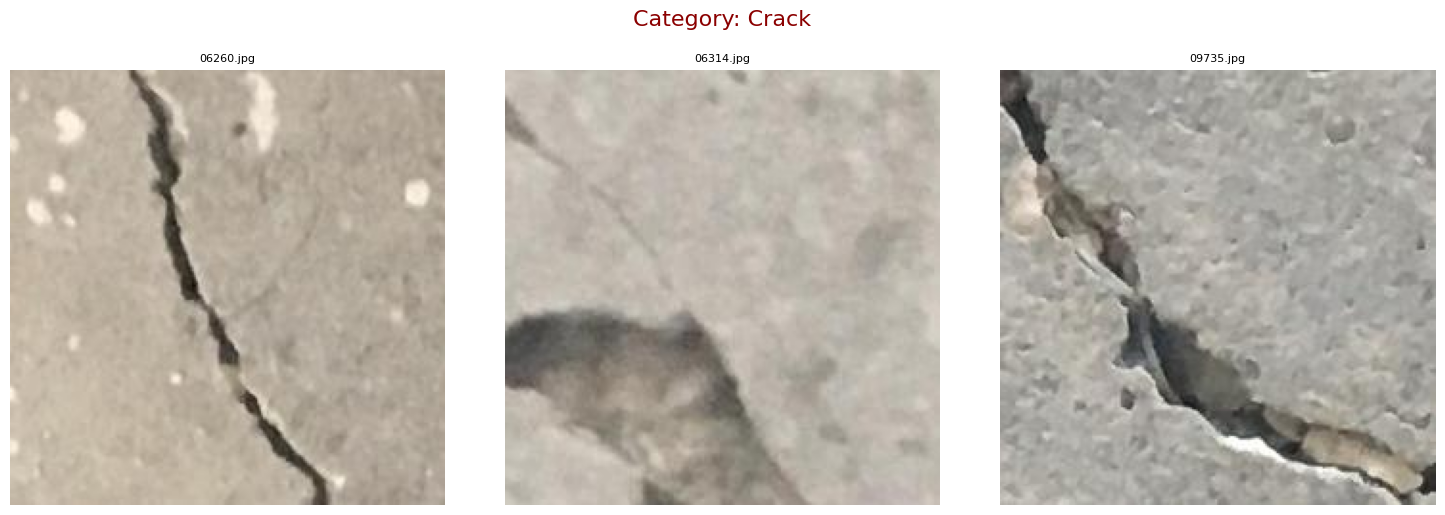

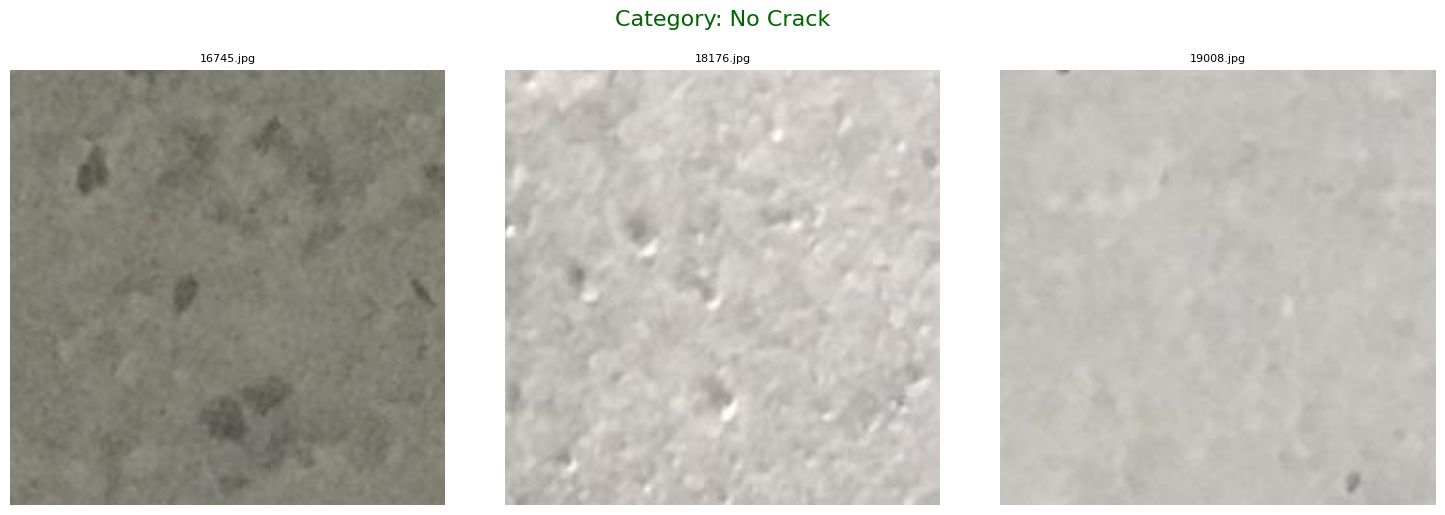

In [ ]:
from PIL import Image
import os
import glob

# Define the path to the sample directory created in the previous step
sample_dir = os.path.join(os.getcwd(), "concrete_sample")

def display_category_images(base_dir, category_name, title_color='black'):
    """
    Finds and displays images for a specific category folder.
    """
    target_dir = os.path.join(base_dir, category_name)

    # Check if directory exists
    if not os.path.exists(target_dir):
        print(f"Directory not found: {target_dir}. Did you run the previous cell?")
        return

    # Find all typical image files in the directory
    image_extensions = ['*.jpg', '*.jpeg', '*.png']
    image_paths = []
    for ext in image_extensions:
        image_paths.extend(glob.glob(os.path.join(target_dir, ext)))
        # Also check lowercase variations just in case
        image_paths.extend(glob.glob(os.path.join(target_dir, ext.upper())))

    # Remove duplicates if any
    image_paths = sorted(list(set(image_paths)))

    num_images = len(image_paths)
    if num_images == 0:
        print(f"No images found in {category_name}")
        return

    # Setup matplotlib figure
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    fig.suptitle(f"Category: {category_name.replace('_', ' ').title()}",
                 fontsize=16, color=title_color, y=1.02)

    # Handle the case where there is only one image (axes is not iterable)
    if num_images == 1:
        axes = [axes]

    for i, img_path in enumerate(image_paths):
        try:
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(os.path.basename(img_path), fontsize=8)
            axes[i].axis('off')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            axes[i].axis('off')
            axes[i].text(0.5, 0.5, "Error loading", ha='center')

    plt.tight_layout()
    plt.show()

# --- Main Execution ---

# Check if the main sample directory exists first
if os.path.exists(sample_dir):
    # Display 'crack' images with a reddish title
    display_category_images(sample_dir, "crack", title_color='darkred')

    # Display 'no_crack' images with a greenish title
    display_category_images(sample_dir, "no_crack", title_color='darkgreen')
else:
    print(f"Sample directory not found at: {sample_dir}")
    print("Please run the previous code block to create the sample dataset first.")

In [ ]:
from tensorflow.keras import layers, models


# 1. Setup Paths
try:
    path = kagglehub.dataset_download("arnavr10880/concrete-crack-images-for-classification")
    print("Path to dataset files:", path)
except:
    print("Using existing path if defined.")

dataset_path = path

# 2. Load Data
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

print(f"Loading images from: {dataset_path}")
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# 3. Optimize for Performance
class_names = train_ds.class_names
print(f"Classes found: {class_names}")
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 4. Build the CNN Architecture
model_cnn = models.Sequential([
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 5. Train
print("Training CNN...")
history_cnn = model_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

# 6. Save the Model
model_cnn.save('crack_detection_model.keras')
print("Model saved as 'crack_detection_model.keras'")

Using Colab cache for faster access to the 'concrete-crack-images-for-classification' dataset.
Path to dataset files: /kaggle/input/concrete-crack-images-for-classification
Loading images from: /kaggle/input/concrete-crack-images-for-classification
Found 40000 files belonging to 2 classes.
Using 32000 files for training.
Found 40000 files belonging to 2 classes.
Using 8000 files for validation.
Classes found: ['Negative', 'Positive']
Training CNN...
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1113s 1s/step - accuracy: 0.9006 - loss: 0.2102 - val_accuracy: 0.9843 - val_loss: 0.0435
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1101s 1s/step - accuracy: 0.9830 - loss: 0.0555 - val_accuracy: 0.9824 - val_loss: 0.1545
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 990s 990ms/step - accuracy: 0.9389 - loss: 0.2557 - val_accuracy: 0.9864 - val_loss: 0.0423
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1059s 1s/step - accuracy: 0.9874 - loss: 0.0416 - val_accuracy: 0.9872 - val_loss: 0.0374
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1049s 1s/step - accuracy: 0.9910 - loss: 0.0310 - val_accuracy: 0.9886 - val_loss: 0.0317
Model saved as 'crack_detection_model.keras'


In [1]:
import gradio as gr
from PIL import Image

# --- LOGIC 1: Strength Prediction (Connected to your ANN) ---
def predict_strength_interface(cement, slag, fly_ash, water, superplast, coarse, fine, age):
    # 1. Prepare the input exactly as the model expects (DataFrame)
    input_dict = {
        'cement': [cement],
        'slag': [slag],
        'fly_ash': [fly_ash],
        'water': [water],
        'superplasticizer': [superplast],
        'coarse_agg': [coarse],
        'fine_agg': [fine],
        'age': [age]
    }
    input_df = pd.DataFrame(input_dict)

    # 2. Scale
    input_scaled = scaler.transform(input_df)

    # 3. Predict
    pred = model.predict(input_scaled, verbose=0)[0][0]

    # 4. Return formatted string
    return f"{pred:.2f} MPa"

# --- LOGIC 2: Crack Detection (Template for your CNN) ---
def detect_crack_interface(image):
    if image is None:
        return "Please upload an image."

    if model_cnn is None:
        return "Model not loaded. Please train the CNN first."

    # 1. Preprocess the image to match training (128x128)
    image = image.resize((128, 128))
    img_array = tf.keras.utils.img_to_array(image)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    # 2. Predict
    prediction = model_cnn.predict(img_array, verbose=0)
    score = prediction[0][0]

    # 3. Logic based on 'Positive' (Crack) vs 'Negative' (No Crack)
    # Usually in this dataset: Positive is Class 1, Negative is Class 0
    if score > 0.5:
        confidence = score * 100
        return f"⚠️ CRACK DETECTED\nConfidence: {confidence:.2f}%"
    else:
        confidence = (1 - score) * 100
        return f"✅ Structure Healthy (No Crack)\nConfidence: {confidence:.2f}%"

# --- UI LAYOUT ---
with gr.Blocks(title="AI Concrete Engineer") as demo:

    gr.Markdown("# 🏗️ AI Concrete Engineering Suite")

    # TAB 1: Mix Design
    with gr.Tab("🧪 Mix Design Optimizer"):
        gr.Markdown("### Predict Compressive Strength based on Mix Proportions")

        with gr.Row():
            with gr.Column():
                cement = gr.Number(label="Cement (kg/m³)", value=350)
                slag = gr.Number(label="Blast Furnace Slag (kg/m³)", value=0)
                fly_ash = gr.Number(label="Fly Ash (kg/m³)", value=0)
                water = gr.Number(label="Water (kg/m³)", value=180)
            with gr.Column():
                superplast = gr.Number(label="Superplasticizer (kg/m³)", value=0)
                coarse = gr.Number(label="Coarse Aggregate (kg/m³)", value=1000)
                fine = gr.Number(label="Fine Aggregate (kg/m³)", value=750)
                age = gr.Number(label="Age (Days)", value=28)

        btn_predict = gr.Button("Predict Strength", variant="primary")
        out_strength = gr.Textbox(label="Predicted Compressive Strength", text_align="center", scale=2)

        # Connect button to function
        btn_predict.click(
            fn=predict_strength_interface,
            inputs=[cement, slag, fly_ash, water, superplast, coarse, fine, age],
            outputs=out_strength
        )

    # TAB 2: Inspection
    with gr.Tab("🔍 Structural Inspection"):
        gr.Markdown("### Upload Site Image for Automated Crack Detection")

        with gr.Row():
            in_image = gr.Image(type="pil", label="Site Photo")
            out_label = gr.Label(label="AI Assessment")

        btn_detect = gr.Button("Analyze Structure", variant="secondary")

        # Connect button to function
        btn_detect.click(
            fn=detect_crack_interface,
            inputs=in_image,
            outputs=out_label
        )

# Launch the app
print("Launching Dashboard...")
demo.launch(share=True, debug=True)

Launching Dashboard...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://32fba1b962bf8d3437.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://32fba1b962bf8d3437.gradio.live
